In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yaml
from collections import defaultdict
from sqlalchemy import create_engine

In [47]:
user = "root"
password = "%40Vicky143"
host = "localhost"
database = "stocks"

engine=create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

In [34]:
def get_all_folders():

    # initialize a default dictionary
    stock_info=defaultdict(list)
    
    # get current working directory
    current=os.getcwd() 
    folder_path=f"{current}\\datasets"
    # list every file/folder inside the datasets folder
    for folder in os.listdir(folder_path):
        file_path=os.path.join(folder_path,folder)
        # list every file/folder inside the folders
        for file in os.listdir(file_path):
            if file.endswith('.yaml'):
                with open(os.path.join(file_path,file),'r') as f:
                    contents=yaml.safe_load(f)
                    for item in contents:
                        stock_info[item["Ticker"]].append({
                            "Ticker":item["Ticker"],
                            "close":item["close"],
                            'date':item['date'],
                            'high':item['high'],
                            'low':item['low'],
                            'month':item['month'],
                            'volume':item['volume']
                        })
    return stock_info          

In [ ]:
stocks_data=get_all_folders()

In [ ]:
for ticker,info in stocks_data.items():
    df=pd.DataFrame(info)
    df.sort_values(by="date",ascending=True)
    file_path=os.path.join(os.getcwd(),'csv_files',f"{ticker}.csv")
    df.to_csv(file_path,sep=",",encoding="utf-8",index=False)

In [36]:
def read_stocks():
    stock_data={}
    folder="csv_files"
    for file in os.listdir(folder):
        if file.endswith(".csv"):
            symbol=file.replace(".csv","")
            df=pd.read_csv(os.path.join(folder,file))
            stock_data[symbol]=df
    return stock_data

In [38]:
stocks_data=read_stocks()
stocks_data["ADANIENT"].head()

,Ticker,close,date,high,low,month,volume
0,ADANIENT,2387.25,2023-10-03 05:30:00,2424.90,2372.00,2023-10,2019899
1,ADANIENT,2464.95,2023-10-04 05:30:00,2502.75,2392.25,2023-10,2857377
2,ADANIENT,2466.35,2023-10-05 05:30:00,2486.50,2446.40,2023-10,1132455
3,ADANIENT,2478.10,2023-10-06 05:30:00,2514.95,2466.05,2023-10,1510035
4,ADANIENT,2442.60,2023-10-09 05:30:00,2459.70,2411.30,2023-10,1408224


In [40]:
stocks_data["SBIN"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  284 non-null    object 
 1   close   284 non-null    float64
 2   date    284 non-null    object 
 3   high    284 non-null    float64
 4   low     284 non-null    float64
 5   month   284 non-null    object 
 6   volume  284 non-null    int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 15.7+ KB


## Yearly Returns

In [43]:
yearly_returns=[]
for symbol,info in stocks_data.items():
    first_close=info.iloc[0,1]
    last_close=info.iloc[-1,1]
    returns=((last_close-first_close)/first_close)*100
    yearly_returns.append({"symbol":symbol,"yearly_returns":returns})
returns_df=pd.DataFrame(yearly_returns)
returns_df.head()

,symbol,yearly_returns
0,ADANIENT,-6.670856
1,ADANIPORTS,36.727207
2,APOLLOHOSP,35.478956
3,ASIANPAINT,-21.935046
4,AXISBANK,9.735363


In [49]:
returns_df.to_sql("yearly_returns",con=engine,if_exists="replace",index=False)

50

## Top 10 Green Stocks

In [52]:
returns_df.sort_values(by="yearly_returns",ascending=False).head(10)

,symbol,yearly_returns
47,TRENT,223.092613
8,BEL,101.760057
30,M&M,95.976974
5,BAJAJ-AUTO,89.011153
9,BHARTIARTL,69.599049
35,POWERGRID,68.854924
10,BPCL,67.477150
20,HEROMOTOCO,58.976655
40,SUNPHARMA,57.282404
17,HCLTECH,53.257447


## Top 10 Red Stocks

In [55]:
returns_df.sort_values(by="yearly_returns",ascending=True).head(10)

,symbol,yearly_returns
24,INDUSINDBK,-30.458409
3,ASIANPAINT,-21.935046
7,BAJFINANCE,-16.110874
0,ADANIENT,-6.670856
22,HINDUNILVR,-0.957916
32,NESTLEIND,0.707141
28,KOTAKBANK,1.991836
6,BAJAJFINSV,2.549566
46,TITAN,3.518185
31,MARUTI,6.926712


## Number Of Green And Red Stocks

In [58]:
green_stocks=returns_df[returns_df["yearly_returns"]>0].shape[0]
red_stocks=returns_df[returns_df["yearly_returns"]<=0].shape[0]
print(f"Green stocks: {green_stocks},\nRed stocks: {red_stocks}")

Green stocks: 45,
Red stocks: 5


## Average closing price and volume accross all stocks

In [61]:
all_closing=[]
all_volume=[]
for stock in stocks_data.values():
    all_closing.extend(stock["close"].to_list())
    all_volume.extend(stock["volume"].to_list())
avg_closing=sum(all_closing)/len(all_closing)
avg_volume=sum(all_volume)/len(all_volume)
print(f"average closing price: {round(avg_closing,2)}\naverage volme: {round(avg_volume,2)}")

average closing price: 2449.42
average volme: 6833474.65


## Volatility Analysis

In [64]:
def calc_daily_returns(df):
    df["daily_returns"]=df["close"].pct_change()
    return df

In [66]:
for symbol,stock in stocks_data.items():
    stocks_data[symbol]=calc_daily_returns(stock)

In [68]:
stocks_data["SBIN"].head()

,Ticker,close,date,high,low,month,volume,daily_returns
0,SBIN,602.95,2023-10-03 05:30:00,604.90,589.60,2023-10,15322196,NaN
1,SBIN,586.25,2023-10-04 05:30:00,600.45,584.45,2023-10,24914612,-0.027697
2,SBIN,592.15,2023-10-05 05:30:00,594.35,587.10,2023-10,13248028,0.010064
3,SBIN,594.25,2023-10-06 05:30:00,598.95,592.20,2023-10,8216780,0.003546
4,SBIN,585.10,2023-10-09 05:30:00,589.00,581.55,2023-10,9189597,-0.015398


In [70]:
volatility=[{"symbol":symbol,"volatility":round(stock["daily_returns"].std(),4)} for symbol,stock in stocks_data.items()]

In [72]:
volat_df=pd.DataFrame(volatility)
top_10_volat=volat_df.sort_values(by="volatility",ascending=False).head(10)
top_10_volat

,symbol,volatility
0,ADANIENT,0.0286
1,ADANIPORTS,0.0260
8,BEL,0.0233
47,TRENT,0.0231
34,ONGC,0.0222
10,BPCL,0.0221
39,SHRIRAMFIN,0.0217
13,COALINDIA,0.0214
21,HINDALCO,0.0196
33,NTPC,0.0195


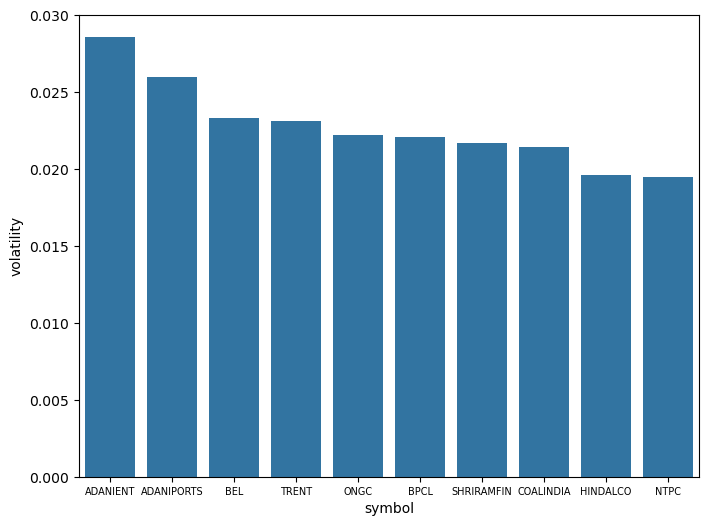

In [74]:
plt.figure(figsize=(8,6))
sns.barplot(data=top_10_volat,x="symbol",y="volatility")
plt.xticks(fontsize=7)
plt.show()

## Cumulative Returns and Best Performing Stock

In [77]:
def calc_cum_returns(df):
    df["cumulative_returns"]=np.round((1+df["daily_returns"]).cumprod()-1,5)
    return df

In [133]:
for symbol,stock in stocks_data.items():
    stocks_data[symbol]=calc_cum_returns(stock)
    stocks_data[symbol].to_csv(f"csv_files/{symbol}.csv",sep=",",encoding="utf-8",index=False)
stocks_data["SBIN"].head()

,Ticker,close,date,high,low,month,volume,daily_returns,cumulative_returns
0,SBIN,602.95,2023-10-03 05:30:00,604.90,589.60,2023-10,15322196,NaN,NaN
1,SBIN,586.25,2023-10-04 05:30:00,600.45,584.45,2023-10,24914612,-0.027697,-0.02770
2,SBIN,592.15,2023-10-05 05:30:00,594.35,587.10,2023-10,13248028,0.010064,-0.01791
3,SBIN,594.25,2023-10-06 05:30:00,598.95,592.20,2023-10,8216780,0.003546,-0.01443
4,SBIN,585.10,2023-10-09 05:30:00,589.00,581.55,2023-10,9189597,-0.015398,-0.02960


In [81]:
cum_returns=[]
for symbol,stock in stocks_data.items():
    cum_returns.append({
        "symbol":symbol,
        "cumulative_returns":stock["cumulative_returns"].iloc[-1]
    })
cum_returns_df=pd.DataFrame(cum_returns)
top_performers=cum_returns_df.sort_values(by="cumulative_returns",ascending=False).head(5)
top_performers

,symbol,cumulative_returns
47,TRENT,2.23093
8,BEL,1.01760
30,M&M,0.95977
5,BAJAJ-AUTO,0.89011
9,BHARTIARTL,0.69599


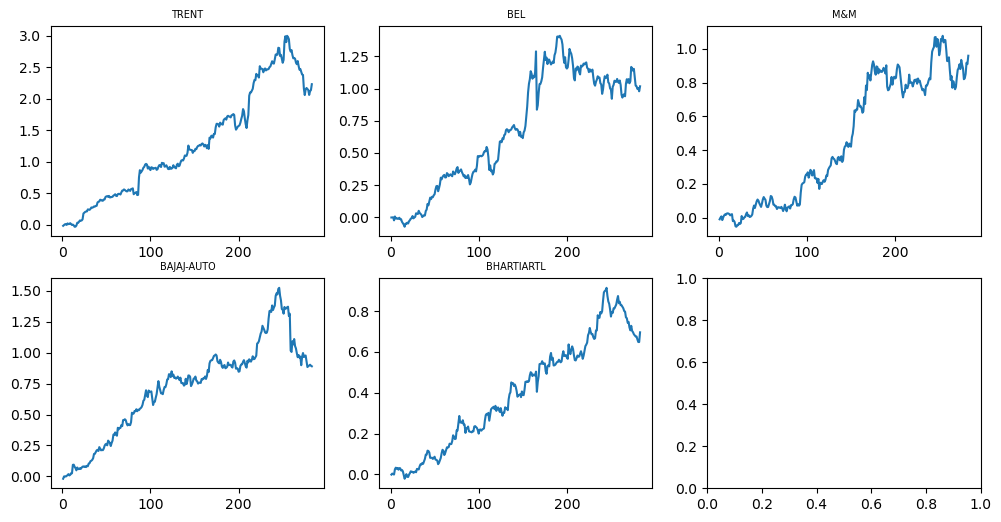

In [83]:
fig,ax=plt.subplots(2,3,figsize=(12,6))
for index,symbol in enumerate(top_performers["symbol"]):
    ax.flat[index].plot(stocks_data[symbol]["cumulative_returns"])
    ax.flat[index].set_title(symbol,fontsize=7)

## Sector-wise Performance

In [86]:
sectors_df=pd.read_csv("sector_data.csv")

In [88]:
sectors_df.head()

,COMPANY,sector,Symbol
0,ADANI ENTERPRISES,MISCELLANEOUS,ADANI ENTERPRISES: ADANIGREEN
1,ADANI PORTS & SEZ,MISCELLANEOUS,ADANI PORTS & SEZ: ADANIPORTS
2,APOLLO HOSPITALS,MISCELLANEOUS,APOLLO HOSPITALS: APOLLOHOSP
3,ASIAN PAINTS,PAINTS,ASIAN PAINTS: ASIANPAINT
4,AXIS BANK,BANKING,AXIS BANK: AXISBANK


In [90]:
def sep_symbols(data):
    symbol=data.split(": ")[1]
    return symbol

In [92]:
sectors_df["Symbol"]=sectors_df["Symbol"].apply(sep_symbols)

In [94]:
sectors_df.head()

,COMPANY,sector,Symbol
0,ADANI ENTERPRISES,MISCELLANEOUS,ADANIGREEN
1,ADANI PORTS & SEZ,MISCELLANEOUS,ADANIPORTS
2,APOLLO HOSPITALS,MISCELLANEOUS,APOLLOHOSP
3,ASIAN PAINTS,PAINTS,ASIANPAINT
4,AXIS BANK,BANKING,AXISBANK


In [98]:
sectors_df.loc["Symbol",0]="ADANIENT"

In [100]:
merged_df=pd.merge(sectors_df,returns_df,left_on="Symbol",right_on="symbol",how="inner")
merged_df.head()

,COMPANY,sector,Symbol,0,symbol,yearly_returns
0,ADANI ENTERPRISES,MISCELLANEOUS,ADANIENT,NaN,ADANIENT,-6.670856
1,ADANI PORTS & SEZ,MISCELLANEOUS,ADANIPORTS,NaN,ADANIPORTS,36.727207
2,APOLLO HOSPITALS,MISCELLANEOUS,APOLLOHOSP,NaN,APOLLOHOSP,35.478956
3,ASIAN PAINTS,PAINTS,ASIANPAINT,NaN,ASIANPAINT,-21.935046
4,AXIS BANK,BANKING,AXISBANK,NaN,AXISBANK,9.735363


In [102]:
sector_perf=merged_df.groupby("sector")["yearly_returns"].mean()
sector_perf

sector
ALUMINIUM           35.868320
AUTOMOBILES         54.526537
BANKING             11.380534
CEMENT              36.970945
DEFENCE            101.760057
ENERGY              36.564788
ENGINEERING         17.253722
FINANCE             11.576063
FMCG                -0.957916
FOOD & TOBACCO       4.321734
INSURANCE           11.767832
MINING              41.846523
MISCELLANEOUS       21.845102
PAINTS             -21.935046
PHARMACEUTICALS     31.379173
POWER               60.184095
RETAILING          113.305399
SOFTWARE            38.275954
STEEL               19.217125
TEXTILES            35.781988
Name: yearly_returns, dtype: float64

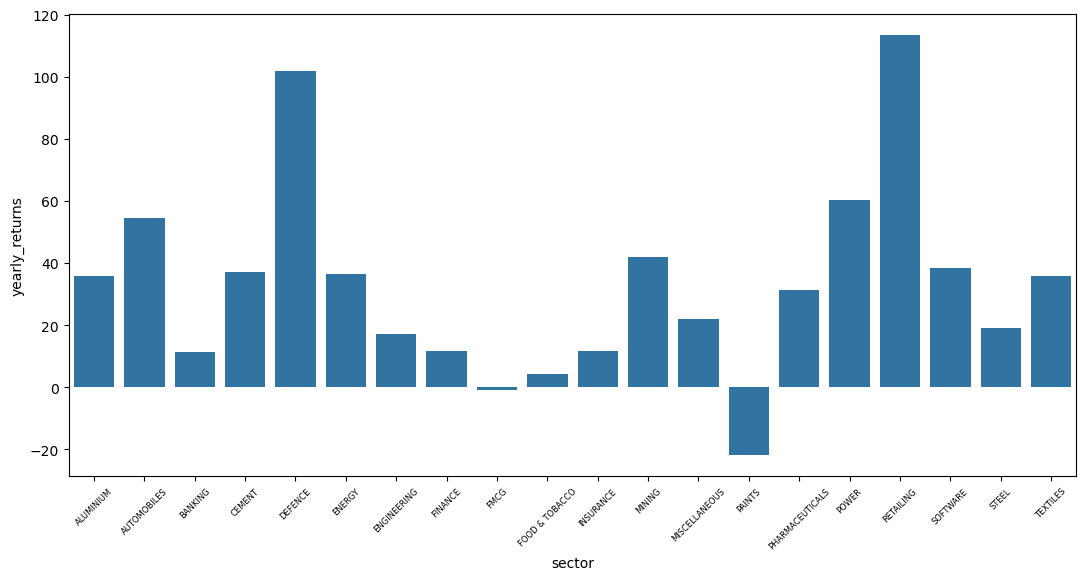

In [104]:
plt.figure(figsize=(13,6))
sns.barplot(x=sector_perf.index,y=sector_perf)
plt.xticks(fontsize=6,rotation=45)
plt.show()

## Stock Price Correlation

In [107]:
price_df=pd.DataFrame()
for symbol,stock in stocks_data.items():
    price_df[symbol]= stock["close"]
price_df

,ADANIENT,ADANIPORTS,APOLLOHOSP,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJFINANCE,BEL,BHARTIARTL,...,SUNPHARMA,TATACONSUM,TATAMOTORS,TATASTEEL,TCS,TECHM,TITAN,TRENT,ULTRACEMCO,WIPRO
0,2387.25,831.40,5118.95,3166.85,1041.05,5016.45,1561.05,7967.60,139.20,925.30,...,1141.45,861.20,620.45,128.00,3513.85,1216.20,3196.25,2059.10,8304.90,405.45
1,2464.95,824.60,5047.40,3169.90,995.55,4918.60,1532.55,7854.05,138.85,924.25,...,1123.80,854.13,613.60,125.30,3537.75,1205.00,3166.65,2022.30,8120.85,404.90
2,2466.35,825.20,5047.05,3206.25,1003.25,5011.05,1542.55,7850.90,138.95,928.85,...,1119.10,849.64,619.60,125.25,3589.35,1205.60,3216.50,2047.60,8177.45,406.80
3,2478.10,830.75,5060.25,3195.75,1000.95,5014.60,1634.65,8168.55,139.00,926.05,...,1127.30,864.01,622.45,125.90,3621.40,1216.90,3309.75,2072.10,8195.45,407.85
4,2442.60,790.05,5047.30,3152.80,996.25,5007.30,1621.55,8027.70,135.75,924.55,...,1123.05,869.84,617.35,123.85,3638.35,1212.65,3267.50,2079.05,8110.10,405.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,2826.80,1264.55,6860.65,2483.15,1140.70,9482.95,1639.80,6549.15,280.95,1550.50,...,1768.20,925.00,774.30,137.98,4145.90,1687.50,3183.70,6463.00,10728.50,566.70
280,2818.70,1279.30,6741.90,2483.70,1126.20,9516.50,1616.00,6567.95,278.05,1537.00,...,1747.75,930.75,771.90,141.21,4019.50,1660.80,3172.30,6301.65,10630.90,552.85
281,2821.50,1289.65,6686.90,2483.70,1133.95,9545.70,1596.35,6595.30,279.00,1525.50,...,1777.25,917.15,783.20,139.46,4039.55,1699.65,3224.70,6423.85,10769.55,562.00
282,2183.65,1114.65,6742.50,2428.15,1139.15,9505.00,1569.25,6465.65,275.45,1525.15,...,1780.00,911.70,773.85,140.22,4072.85,1702.25,3178.45,6460.45,10954.85,557.15


In [109]:
pct_diff=price_df.pct_change()
pct_diff.head()

,ADANIENT,ADANIPORTS,APOLLOHOSP,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJFINANCE,BEL,BHARTIARTL,...,SUNPHARMA,TATACONSUM,TATAMOTORS,TATASTEEL,TCS,TECHM,TITAN,TRENT,ULTRACEMCO,WIPRO
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.032548,-0.008179,-0.013977,0.000963,-0.043706,-0.019506,-0.018257,-0.014251,-0.002514,-0.001135,...,-0.015463,-0.008209,-0.011040,-0.021094,0.006802,-0.009209,-0.009261,-0.017872,-0.022162,-0.001357
2,0.000568,0.000728,-0.000069,0.011467,0.007734,0.018796,0.006525,-0.000401,0.000720,0.004977,...,-0.004182,-0.005257,0.009778,-0.000399,0.014586,0.000498,0.015742,0.012511,0.006970,0.004693
3,0.004764,0.006726,0.002615,-0.003275,-0.002293,0.000708,0.059706,0.040460,0.000360,-0.003014,...,0.007327,0.016913,0.004600,0.005190,0.008929,0.009373,0.028991,0.011965,0.002201,0.002581
4,-0.014325,-0.048992,-0.002559,-0.013440,-0.004696,-0.001456,-0.008014,-0.017243,-0.023381,-0.001620,...,-0.003770,0.006748,-0.008193,-0.016283,0.004681,-0.003492,-0.012765,0.003354,-0.010414,-0.005517


In [111]:
price_corr=pct_diff.corr()

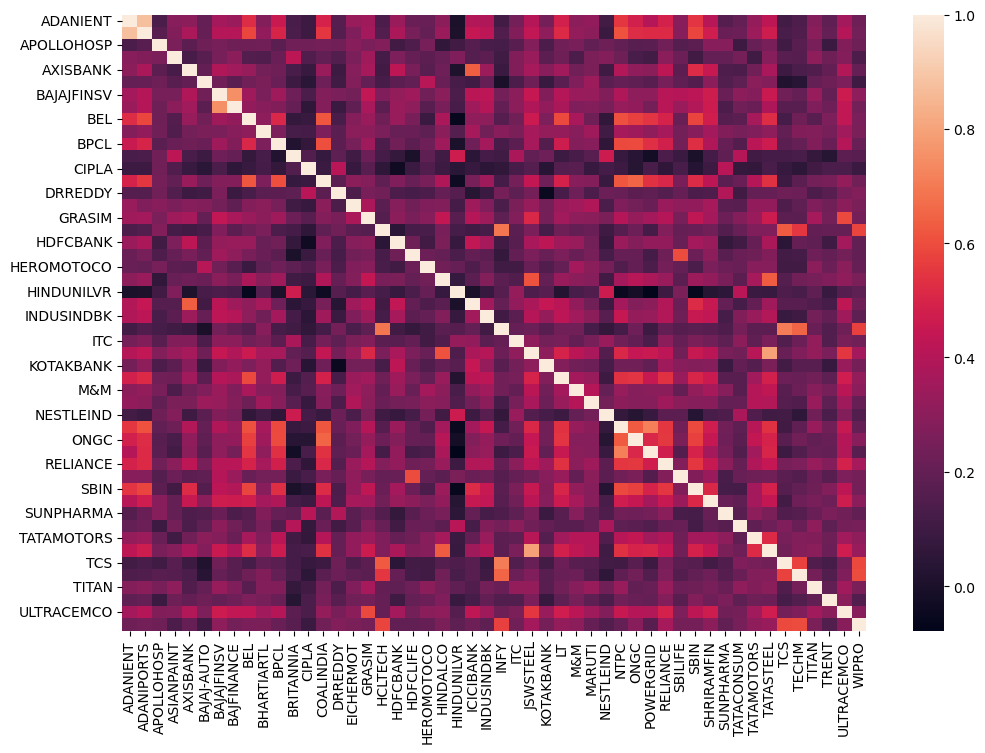

In [113]:
plt.figure(figsize=(12,8))
sns.heatmap(price_corr)
plt.show()

## Monthly Top 5 Gainers and Losers 

In [115]:
monthly_returns=[]
for symbol,stock in stocks_data.items():
    grouped=stock.groupby('month')
    
    for month,group in grouped:
        first=group["close"].iloc[0]
        last=group["close"].iloc[-1]
        returns=((last-first)/first)*100
        monthly_returns.append({"symbol":symbol,"month":month,"returns":returns})
monthly_returns_df=pd.DataFrame(monthly_returns)
monthly_returns_df.head(5)

,symbol,month,returns
0,ADANIENT,2023-10,-3.878940
1,ADANIENT,2023-11,6.370360
2,ADANIENT,2023-12,20.580268
3,ADANIENT,2024-01,7.706019
4,ADANIENT,2024-02,4.182654


In [117]:
months=monthly_returns_df["month"].unique()

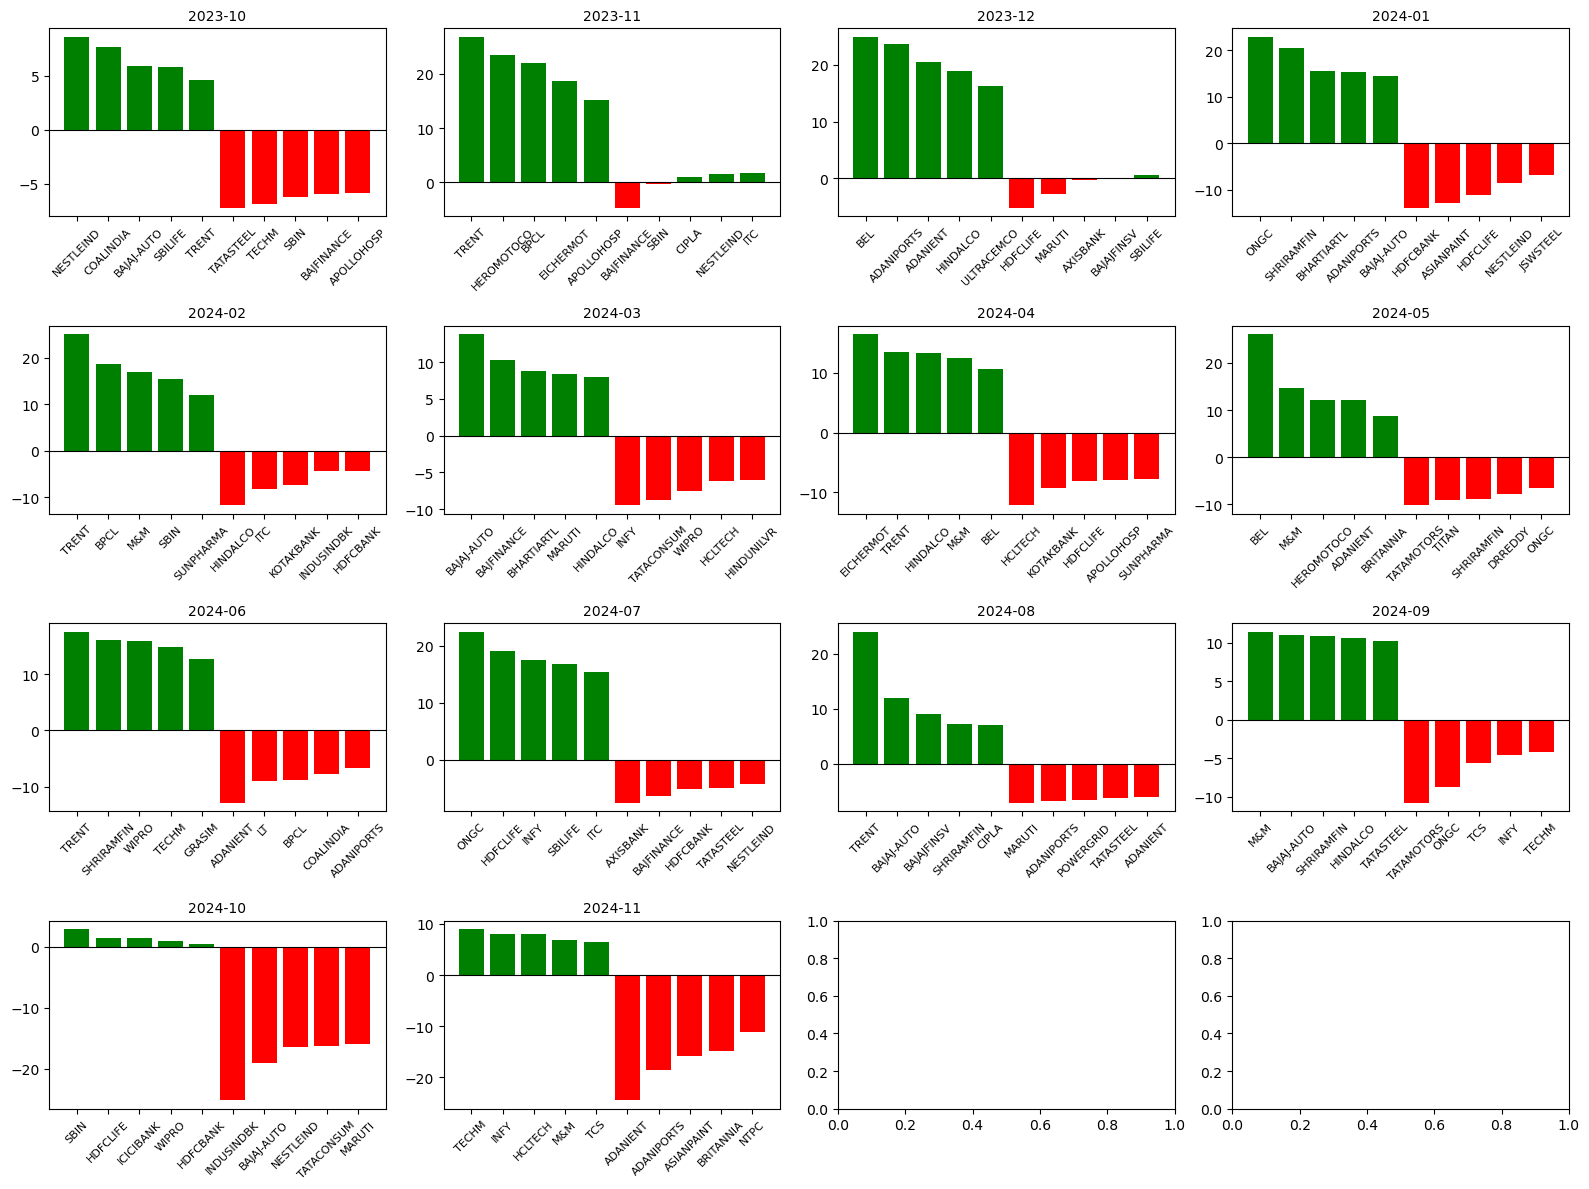

In [120]:
fig,ax=plt.subplots(4,4,figsize=(16,12))
for index,month in enumerate(months):
    month_df=monthly_returns_df[monthly_returns_df["month"]==month]
    top5=month_df.sort_values(by='returns',ascending=False).head(5)
    bottom5=month_df.sort_values(by="returns").head(5)
    conc=pd.concat([top5,bottom5])
    ax.flat[index].bar(
    conc["symbol"],
    conc["returns"],
    color=['green' if r>0 else 'red' for r in conc["returns"]])

    ax.flat[index].set_title(str(month), fontsize=10)
    ax.flat[index].tick_params(axis='x', rotation=45, labelsize=8)
    ax.flat[index].axhline(0, color='black', linewidth=0.8)
    
    plt.tight_layout()

In [121]:
for symbol,stock in stocks_data.items():
    stock.to_sql(symbol.lower(),con=engine,index=False,if_exists='replace')